In [1]:
import cppapi
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getcwd())
os.chdir('/home/thomas/cpp-projects/low-level-deep-learning/')
print(os.getcwd())

from python_tests.test_activation import leaky_relu, sigmoid

/home/thomas/cpp-projects/low-level-deep-learning/examples
/home/thomas/cpp-projects/low-level-deep-learning


In [2]:
# create some comparision differentiable functions to view with api
# simultaneously 

def square(x: np.ndarray):
    return x * x

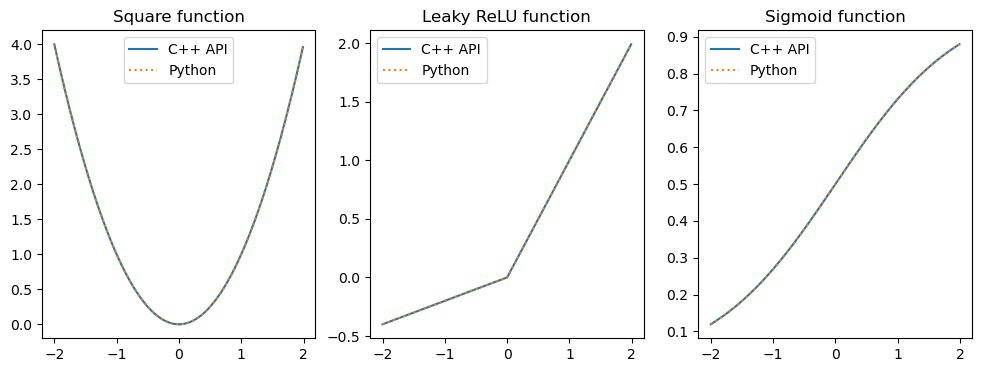

In [3]:
input_range = np.arange(-2, 2, 0.01)

square_api_output = cppapi.square(input_range)
square_py_output = square(input_range)

relu_api_output = cppapi.leaky_relu(input_range)
relu_py_output = leaky_relu(input_range)

sigmoid_api_output = cppapi.sigmoid(input_range)
sigmoid_py_output = sigmoid(input_range)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(input_range, square_api_output, label='C++ API')
ax[0].plot(input_range, square_py_output, ls=':', label='Python')
ax[0].set_title("Square function")
ax[0].legend()

ax[1].plot(input_range, relu_api_output, label='C++ API')
ax[1].plot(input_range, relu_py_output, ls=':', label='Python')
ax[1].set_title("Leaky ReLU function")
ax[1].legend()

ax[2].plot(input_range, sigmoid_api_output, label='C++ API')
ax[2].plot(input_range, sigmoid_py_output, ls=':', label='Python')
ax[2].set_title("Sigmoid function")
ax[2].legend()

plt.show()

In [4]:
from typing import Callable, List
from python_tests.test_activation import sigmoid, square

def deriv(func: Callable[[np.ndarray], np.ndarray],
          input_: np.ndarray,
          delta: float = 0.001) -> np.ndarray:
    return (func(input_ + delta) - func(input_ - delta)) / (2 * delta)
    
Array_Function = Callable[[np.ndarray], np.ndarray]
Chain = List[Array_Function]

def forward2(chain: Chain, input_range: np.ndarray) -> np.ndarray:
    f1 = chain[0]
    f2 = chain[1]
    return f2(f1(input_range))
    
def chain_derivative2(chain: Chain, input_range: np.ndarray) -> np.ndarray:
    f1 = chain[0]
    f2 = chain[1]
    
    f1_of_x = f1(input_range)
    df1dx = deriv(f1, input_range)
    df2du = deriv(f2, f1_of_x)
    
    return df1dx * df2du

input_range = np.arange(-3, 3, 0.01).astype(np.float32)

chain1 = [square, sigmoid]

py_output = chain_derivative2(chain1, input_range)
cpp_output = cppapi.chain_derivative(cppapi.Activation.SQUARE, cppapi.Activation.SIGMOID, input_range)

py_forward2 = forward2(chain1, input_range=input_range)
cpp_forward2 = cppapi.chain(cppapi.Activation.SQUARE, cppapi.Activation.SIGMOID, input_range)

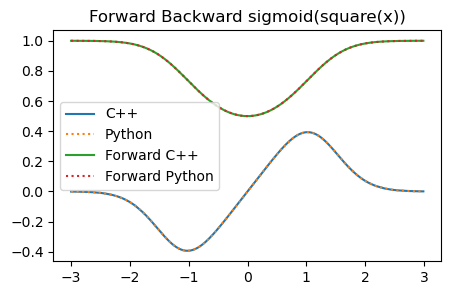

In [5]:
plt.figure(figsize=(5, 3))
plt.plot(input_range, cpp_output, label='C++')
plt.plot(input_range, py_output, ls=':', label='Python')
plt.plot(input_range, cpp_forward2, label='Forward C++')
plt.plot(input_range, py_forward2, ls=':', label='Forward Python')
plt.title('Forward Backward sigmoid(square(x))')
plt.legend()

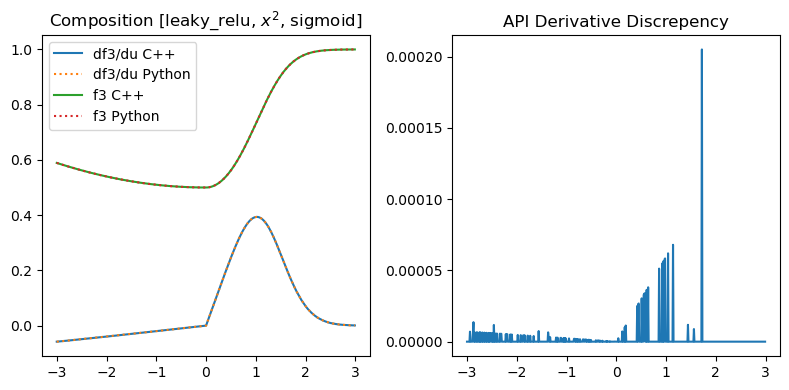

In [7]:
chain2 = [leaky_relu, square, sigmoid]

def chain_derivative3(chain: Chain, input_range: np.ndarray) -> np.ndarray:
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]
    
    f1_of_x = f1(input_range)
    df1dx = deriv(f1, input_range)
    df2du = deriv(f2, f1_of_x)
    f2_of_x = f2(f1_of_x)
    df3du = deriv(f3, f2_of_x)
    return df1dx * df2du * df3du

def chain3(chain: Chain, input_range: np.ndarray) -> np.ndarray:
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]
    return f3(f2(f1(input_range)))

input_range = np.arange(-3, 3, 0.01).astype(np.float32)
chain = [leaky_relu, square, sigmoid]
pyforward = chain3(chain, input_range)
cppforward = cppapi.chain3(cppapi.Activation.LEAKY_RELU, cppapi.Activation.SQUARE,
                           cppapi.Activation.SIGMOID, input_range)
pyoutput = chain_derivative3(chain, input_range=input_range)
cpp_output = cppapi.chain_derivative3(cppapi.Activation.LEAKY_RELU, cppapi.Activation.SQUARE,
                                        cppapi.Activation.SIGMOID, input_range)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(input_range, cpp_output, label='df3/du C++')
ax[0].plot(input_range, pyoutput, label='df3/du Python', ls=':')
ax[0].plot(input_range, pyforward, label='f3 C++')
ax[0].plot(input_range, cppforward.squeeze(), label='f3 Python', ls=':')
ax[0].set_title("Composition [leaky_relu, $x^2$, sigmoid]")
ax[0].legend()
ax[1].plot(input_range, np.abs(cpp_output.squeeze() - pyoutput))
ax[1].set_title("API Derivative Discrepency")
plt.tight_layout()
plt.show()